### Chapter 11

# CNN 모델 FashionMNIST

> ## 학습 목표
- CNN(Convolutional Neural Network) 모델을 효과적으로 설계하고 구현할 수 있다.
- FashionMNIST 데이터셋을 통해 CNN을 활용한 이미지 분류 작업에 대한 실무에 적용할 수 있다.
- PyTorch 프레임워크를 사용하여 모델의 성능을 평가하고, 최적화 기법을 적용하여 과적합 및 과소적합 문제를 해결하는 방법을 이해한다.
- 훈련 과정에서 정확도와 손실 값을 시각화하고 이를 통해 모델 학습의 경향을 분석하여, 지속적인 성능 개선을 위한 전략을 수립할 수 있다.

## **11.1 CNN 모델 구현**

**CNN은 주로 이미지 분류에 사용되는 신경망으로, 기본적으로 합성곱(Convolutional) 층, 풀링(Pooling) 층, 그리고 완전 연결(Fully Connected) 층으로 구성됩니다.**

> ### 기본적인 CNN 모델 구조

- Convolutional Layer (합성곱층): 이미지에서 특징을 추출하는 역할을 합니다.
- Activation Function (활성화 함수): 일반적으로 ReLU(Rectified Linear Unit) 함수를 사용하여 비선형성을 추가합니다.
- Pooling Layer (풀링층): 이미지의 크기를 줄여서 계산량을 감소시키고, 특징을 요약합니다.
- Fully Connected Layer (완전 연결층): 추출된 특징을 기반으로 분류를 수행합니다.

### 11.1.1. 라이브러리 임포트

In [1]:
import torch   # torch: PyTorch의 핵심 패키지로 텐서 연산 등을 제공.
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms 
# torchvision: PyTorch에서 컴퓨터 비전용 데이터셋, 모델 등을 제공.

### 11.1.2. CNN 모델 - 데이터 전처리 설정

In [2]:
# 데이터 전처리 설정
transform = transforms.Compose([
    transforms.ToTensor(), 
    # 이미지를 텐서로 변환 
    # transforms.ToTensor(): PIL 이미지나 NumPy 배열을 PyTorch 텐서로 변환.
    transforms.Normalize((0.1307,), (0.3081,))  # 평균과 표준편차로 정규화 
])

# 데이터셋 로드
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# datasets.MNIST: MNIST 데이터셋을 로드.
# train=True: 훈련 데이터 로드.
# train=False: 테스트 데이터 로드.
# download=True: 데이터셋이 없으면 다운로드.

# 데이터 로더 설정
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# DataLoader: 데이터셋을 배치(batch)단위로 분리, 반복 가능(iterable)하게 설정
# batch_size: 한 번에 처리할 데이터 샘플 수.
# shuffle: 데이터를 무작위로 섞을지 여부.

> ### CNN 모델 정의

- 모델을 클래스 형태로 정의하며, nn.Module을 상속받습니다.
- `__init__` 메서드에서 레이어를 초기화하고, forward 메서드에서 순전파(forward pass)를 정의합니다.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # 첫 번째 합성곱 레이어
        # 입력 채널 1, 출력 채널 32, 커널 크기 3x3, 스트라이드 1
        
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # 두 번째 합성곱 레이어
        # 입력 채널 32, 출력 채널 64, 커널 크기 3x3, 스트라이드 1

        # 2x2 최대 풀링 레이어 정의
        self.pool = nn.MaxPool2d(2) 

        # 첫 번째 전결합 층: 입력 9216, 출력 128
        # 9216 = 64채널 * 12 * 12 픽셀 (풀링 후 크기)
        self.fc1 = nn.Linear(9216, 128)

        # 두 번째 전결합 층: 입력 128, 출력 10 (클래스 수)
        self.fc2 = nn.Linear(128, 10)    

    def forward(self, x):
        # 첫 번째 합성곱 레이어와 ReLU 활성화 함수 적용
        x = F.relu(self.conv1(x))  # 출력 크기: [batch_size, 32, 26, 26]

        # 두 번째 합성곱 레이어와 ReLU 활성화 함수 적용
        x = F.relu(self.conv2(x))  # 출력 크기: [batch_size, 64, 24, 24]

        # 최대 풀링 적용
        x = self.pool(x)           # 출력 크기: [batch_size, 64, 12, 12]

        # 텐서를 1D 형태로 펼치기 (batch_size에 따라 자동 결정)
        x = x.view(-1, 9216)       # 출력 크기: [batch_size, 9216]

        # 첫 번째 전결합 층과 ReLU 활성화 함수 적용
        x = F.relu(self.fc1(x))    # 출력 크기: [batch_size, 128]

        # 두 번째 전결합 층 통과 (최종 클래스 예측)
        x = self.fc2(x)            # 출력 크기: [batch_size, 10]

        return x  # 모델의 최종 출력 반환

### 11.1.3. 모델 인스턴스 생성, 모델 요약 출력, 손실 함수 및 옵티마이저 설정
- 모델은 합성곱 레이어, 활성화 함수, 풀링 레이어, 완전 연결층 등을 포함하여 이미지 분류 작업을 수행할 수 있도록 구성됩니다. 
- 필요에 따라 레이어의 수나 파라미터를 조정하여 성능을 최적화할 수 있습니다.

In [4]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

# 크로스엔트로피오차 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 함수
def train(model, device, train_loader, optimizer, epoch):
    model.train() 
    # 모델을 학습 모드로 전환
    # model.train(): 드롭아웃, 배치 정규화 등 학습 시에만 사용되는 기능 활성화
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  
        # 데이터와 레이블을 장치에 할당
        optimizer.zero_grad() # 기울기 초기화
        output = model(data)  # 모델에 입력 데이터 전달하여 예측값 계산
        loss = criterion(output, target)  # 손실 계산
        loss.backward()  # 역전파 단계, 역전파를 통해 기울기 계산
        optimizer.step() # 가중치 업데이트, 역전파를 통해 기울기 계산

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# 평가 함수
def test(model, device, test_loader):
    model.eval()  
    # 모델을 평가 모드로 전환
    # model.eval(): 드롭아웃, 배치 정규화 등 평가 시에만 사용되는 기능 비활성화.
    test_loss = 0
    correct = 0
    with torch.no_grad():  
    # 기울기 계산 비활성화
    # torch.no_grad(): 기울기 계산을 하지 않아 메모리 사용량 감소 및 속도 향상.
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  
            # 데이터와 레이블을 장치에 할당
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)  
            # 배치 손실 합산
            pred = output.argmax(dim=1, keepdim=True) 
            # 가장 높은 값을 가진 클래스 선택
            # output.argmax(dim=1): 각 샘플에 대한 예측 클래스 반환.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)  # 평균 손실 계산
    accuracy = 100. * correct / len(test_loader.dataset)  # 정확도 계산

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
        f' ({accuracy:.2f}%)\n')
    
    # 학습 및 평가 실행
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
# GPU 사용 여부 결정, GPU를 사용할 수 있으면 사용하고, 아니면 CPU 사용
model.to(device) 
# 모델을 장치에 할당, model.to(device): 모델의 파라미터를 장치에 할당.

num_epochs = 5  
# 학습 에포크 수, num_epochs: 전체 데이터셋을 몇 번 반복 학습할지 결정.

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316330
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.195350
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.056199
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.065813
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.076254
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.019584
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.052714
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.271848
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.016309
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.140301

Test set: Average loss: 0.0441, Accuracy: 9848/10000 (98.48%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.012554
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.046590
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.097449
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.142734
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.009168
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.002218
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.002659
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.001754
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.07314

In [144]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  
        # 데이터와 타겟을 GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        output = model(data)  # 데이터 처리
        loss = criterion(output, target)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        total_loss += loss.item()  # 손실 축적

        if batch_idx % 100 == 0:  # 간헐적으로 손실 출력
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    return total_loss / len(train_loader)  # 평균 손실 반환

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
# GPU 사용 가능시 GPU로 설정
model = model.to(device)  # 모델을 GPU로 이동


In [149]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        output = model(data)  # 데이터 처리
        loss = criterion(output, target)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        # 손실 출력
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # GPU로 이동
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
        f' ({accuracy:.2f}%)\n')
    
    return test_loss, accuracy  # 평균 손실과 정확도 반환

In [150]:
# 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim

# 모델 클래스 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 784)  # 입력 평탄화
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.logsoftmax(x)

# 환경 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)  # 모델을 장치로 이동

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 여기에 train_loader, test_loader 설정이 필요합니다.

# 훈련 반복
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, device, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.265535
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.321328
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.510699
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.680294
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.675542
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.360017
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.410181
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.383367
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.291321
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.239140

Test set: Average loss: 0.4208, Accuracy: 8497/10000 (84.97%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.456794
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.233934
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.339180
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.338250
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.521829
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.395029
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.291460
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.307787
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.27378

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323936
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.610024
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.619612
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.369379
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.377850
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.444405
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.298106
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.481602
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.507224
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.368587

Test set: Average loss: 0.4150, Accuracy: 8526/10000 (85.26%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.360862
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.205947
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.360265
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.376444
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.330116
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.379416
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.280437
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.412576
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.42745

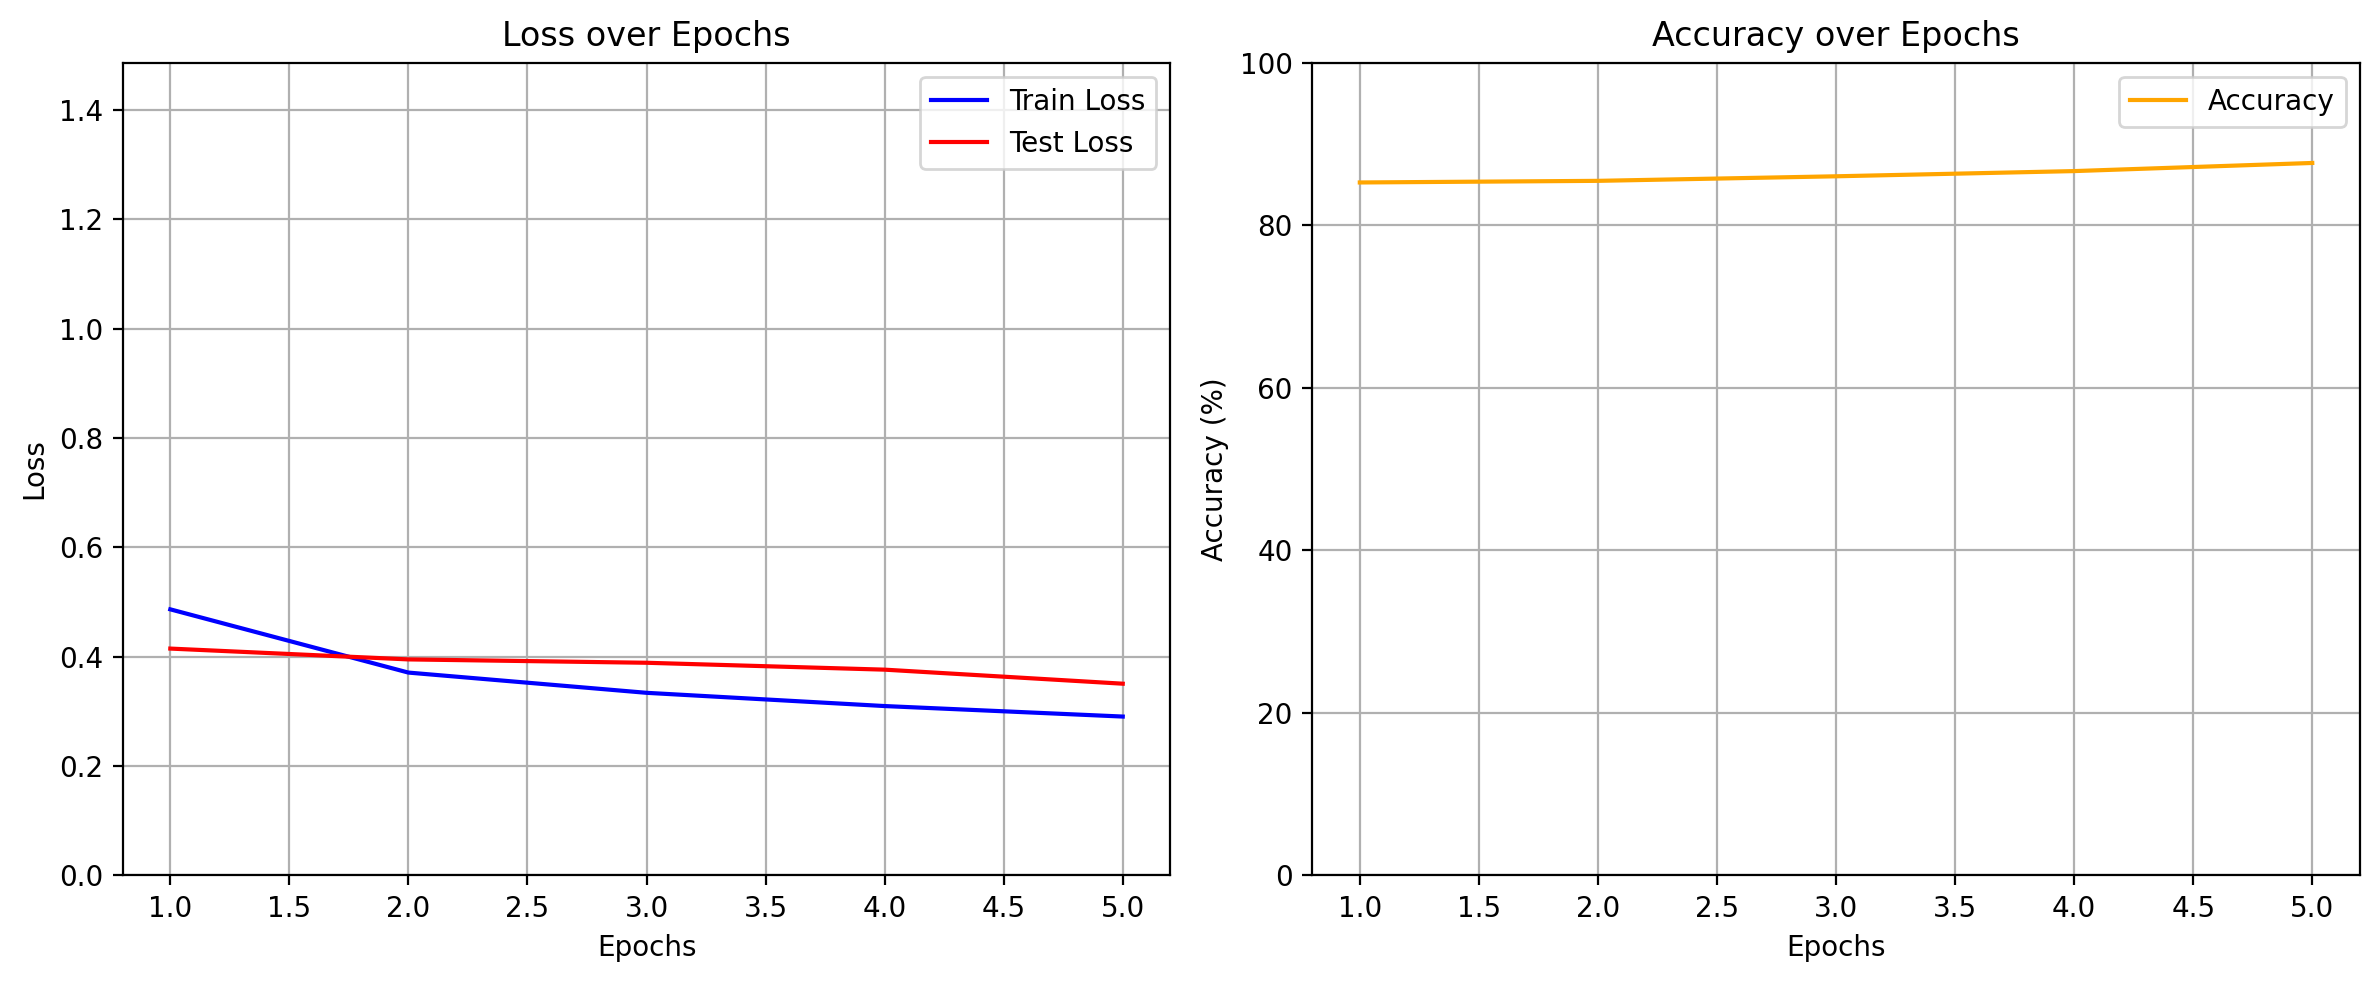

In [164]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 784)  # 입력 평탄화
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.logsoftmax(x)

# 장치 설정 및 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실과 정확도를 저장할 리스트 생성
train_losses = []
test_losses = []
accuracies = []

# 에포크 수 설정
num_epochs = 5

# 모델 훈련 및 테스트
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, device, test_loader)
    
    # 손실과 정확도 기록
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

# 결과 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, max(max(train_losses), max(test_losses)) + 1)  # Y축 범위 설정
plt.legend()
plt.grid()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Y축 범위 설정
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

5. 그래프 표시 방식 점검

시각화가 제대로 표시되지 않거나 단순히 보이지 않을 수 있습니다. Jupyter Notebook 사용 시 경우에 따라, %matplotlib inline을 선언하여 그래프가 바로 나타나게 해주기도 합니다:

In [165]:
%matplotlib inline

결론

위의 확인 사항을 하나하나 점검해보시고, 훈련 손실 값이 리스트에 잘 저장되고 그래프에 올바르게 표시되도록 수정해 보세요. 여전히 문제가 지속된다면 추가로 정보를 제공해 주시면 더 도와드릴 수 있습니다.

In [166]:
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, device, test_loader)
    
    # 손실과 정확도 기록
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

# 손실 값 기록 확인
print(f"Train Losses: {train_losses}")
print(f"Test Losses: {test_losses}")


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.270997
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.261876
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.277826
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.321509
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.333401
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.291623
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.290069
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.168371
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.264432
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.337137

Test set: Average loss: 0.3712, Accuracy: 8675/10000 (86.75%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.187697
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.263923
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.164850
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.217311
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.402402
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.217531
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.152258
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.178965
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.15031

In [167]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # 데이터 및 타겟을 GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        output = model(data)  # 데이터 처리
        loss = criterion(output, target)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        total_loss += loss.item()  # 손실 축적

    return total_loss / len(train_loader)  # 평균 손실 반환


In [171]:
# 손실 값이 비어 있지 않다면 시각화
if train_losses:
    plt.ylim(min(train_losses) - 1, max(train_losses) + 1)  # Y축 범위 설정
else:
    print("Train losses is empty!")


In [172]:
# 모델 훈련 및 테스트
num_epochs = 5  # 에포크 수 설정

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, device, test_loader)
    
    # 리스트에 저장
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)



Test set: Average loss: 0.3485, Accuracy: 8843/10000 (88.43%)


Test set: Average loss: 0.3501, Accuracy: 8861/10000 (88.61%)


Test set: Average loss: 0.3449, Accuracy: 8864/10000 (88.64%)


Test set: Average loss: 0.3700, Accuracy: 8812/10000 (88.12%)


Test set: Average loss: 0.3893, Accuracy: 8803/10000 (88.03%)



In [173]:
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)
print("Accuracy:", accuracy)

Train Loss: 0.19010226457103738
Test Loss: 0.38931835131645204
Accuracy: 88.03


In [175]:
# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Y축 범위 설정
if train_losses and test_losses:
    plt.ylim(min(min(train_losses), min(test_losses)) - 1, max(max(train_losses), max(test_losses)) + 1)  # Y축 범위 설정
else:
    plt.ylim(0, 1)  # 기본값 설정

plt.legend()
plt.grid()

In [176]:
%matplotlib inline

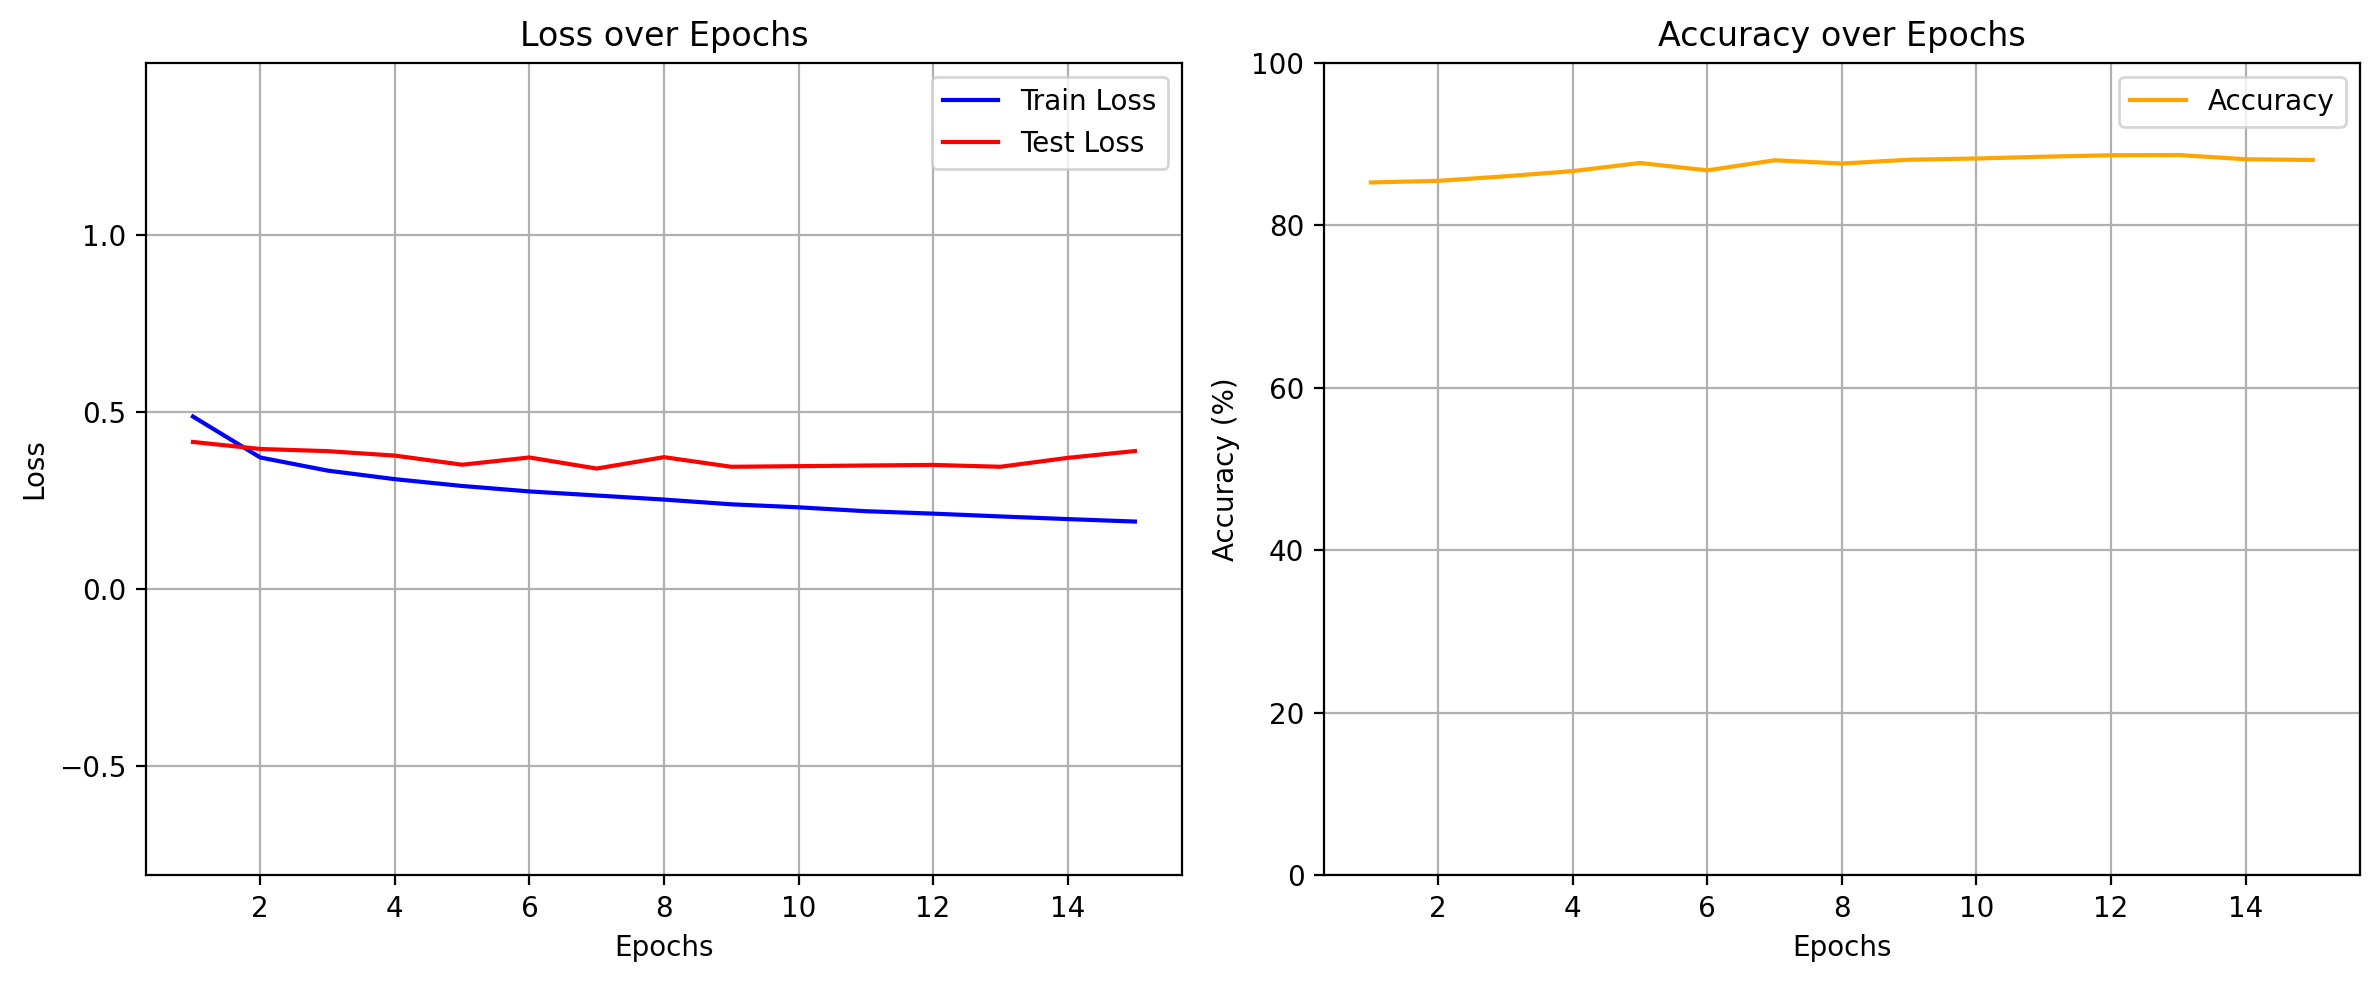

In [178]:
import matplotlib.pyplot as plt

# 결과 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Y축 범위 설정
if train_losses and test_losses:
    plt.ylim(min(min(train_losses), min(test_losses)) - 1, max(max(train_losses), max(test_losses)) + 1)  # Y축 범위 설정
else:
    plt.ylim(0, 1)  # 기본값 설정

plt.legend()
plt.grid()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Y축 범위 설정

plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # 그래프 출력


In [179]:
print(f"Train Losses: {train_losses}")
print(f"Test Losses: {test_losses}")
print(f"Accuracies: {accuracies}")

Train Losses: [0.4867786391457515, 0.37107709639552816, 0.3340725209444825, 0.3098567886980993, 0.29064567800142616, 0.2752144155678337, 0.2637417329781091, 0.2522021722691908, 0.23885402724003868, 0.2303291156864179, 0.21933794293655898, 0.21251328517871498, 0.2045790521201612, 0.1970733681610271, 0.19010226457103738]
Test Losses: [0.41498525071144104, 0.3951829610109329, 0.389043802344799, 0.3764387103199959, 0.3507496441185474, 0.3711547786593437, 0.33986345603466034, 0.3720774884223938, 0.34486084226369856, 0.3466038199067116, 0.34847464250326154, 0.35008587993383405, 0.34489720153808595, 0.37002681710720065, 0.38931835131645204]
Accuracies: [85.26, 85.46, 86.02, 86.66, 87.66, 86.75, 87.99, 87.59, 88.06, 88.21, 88.43, 88.61, 88.64, 88.12, 88.03]


----

## **11. 2 CNN 모델 구현 실습**

> ## FashionMNIST을 이용한 CNN 모델 구현

**FashionMNIST**는 머신러닝 및 컴퓨터 비전 분야에서 널리 사용되는 데이터셋입니다. 
- Zalando의 기사 이미지 데이터 세트로, 60,000개의 예제로 구성된 훈련 세트와 10,000개의 예제로 구성된 테스트 세트로 구성되어 있습니다. 각 예제는 28x28 회색조 이미지이며, 10개 클래스의 레이블과 연관되어 있습니다. 
- https://www.kaggle.com/datasets/zalando-research/fashionmnist
- 원본 데이터 세트는 https://github.com/zalandoresearch/fashion-mnist


### 11.2.1 기본 정보

-   **목적**: FashionMNIST는 패션 아이템 분류 문제를 해결하기 위한 데이터셋으로, 복잡한 이미지 인식 작업에서 신경망 학습의 유용성을 demonstrate하기 위해 만들어졌습니다.
-   **형태**: FashionMNIST는 10개의 서로 다른 카테고리로 나누어진 28x28 픽셀의 흑백 이미지로 이루어져 있습니다.

### 11.2.2 데이터셋 구성

-   **훈련 데이터**: 60,000개의 이미지
-   **테스트 데이터**: 10,000개의 이미지
-   **총 이미지 수**: 70,000개

### 11.2.3 클래스

FashionMNIST는 다음과 같은 10개의 클래스 레이블을 포함하고 있습니다:

0.  티셔츠/top (T-shirt/top)
1.  바지 (Trouser)
2.  풀오버 (Pullover)
3.  드레스 (Dress)
4.  코트 (Coat)
5.  샌들 (Sandal)
6.  셔츠 (Shirt)
7.  운동화 (Sneaker)
8.  가방 (Bag)
9.  앵클 부츠 (Ankle boot)

### 11.2.4 사용 이유

-   **대체 데이터셋**: FashionMNIST는 전통적인 MNIST 데이터셋(손글씨 숫자)을 대체하기 위해 설계되었습니다. 패션 아이템의 분류로 더욱 복잡한 시각적 문제를 해결할 수 있도록 돕습니다.
-   **단순성**: 구조가 간단하여 초보자들이 CNN 및 다른 알고리즘을 실험하는 데 적합합니다.
-   **다양성**: 패션 데이터의 다양한 카테고리로 인해 더 복잡한 분류 작업을 테스트할 수 있습니다.

### 11.2.5 접근 방법

FashionMNIST 데이터셋은 PyTorch, TensorFlow 등 다양한 머신러닝 프레임워크에서 쉽게 불러와 사용할 수 있는 형태로 제공됩니다.

결론적으로, FashionMNIST는 머신러닝 모델을 학습하고 평가하는 데 유용한 데이터셋으로, 이미지 분류 문제를 해결하는 데 널리 사용됩니다.

1) 라이브러리 불러오기

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

2) 데이터셋 준비

- FashionMNIST 데이터셋을 다운로드하고, 데이터를 전처리할 트랜스폼을 정의합니다.

In [6]:
# 데이터 전처리 (Tensor로 변환하고, 정규화)
transform = transforms.Compose([
    transforms.ToTensor(),                # 이미지를 Tensor로 변환
    transforms.Normalize((0.5,), (0.5,))  # 정규화 (0~1 사이로 스케일링)
])

# 학습 데이터셋과 테스트 데이터셋 불러오기
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

3. CNN 모델 정의

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
                
        # Convolutional layer 1 (합성곱 층)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Convolutional layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Fully connected layer
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes (FashionMNIST의 클래스 수)

    def forward(self, x):
        # Convolution + MaxPooling + ReLU Activation
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Flatten(다차원 배열을 1차원 벡터로 변환)
        x = x.view(-1, 64 * 7 * 7)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # 마지막 출력층 (Logits)
        
        return x

4. 모델 학습 설정
- 모델을 학습시키기 위한 손실 함수와 최적화 알고리즘을 정의합니다.

In [8]:
# 모델 초기화
model = CNN()

# 손실 함수 (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# 최적화 알고리즘 (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

5. 모델 학습

In [9]:
""" 
#device 설정
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = CNN().to(device)
"""
# CPU 사용 설정
device = torch.device("cpu")

# 모델을 device로 이동
model = model.to(device)


In [10]:
# 학습 함수
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            # GPU 사용 가능시 모델을 GPU로 이동
            #inputs, labels = inputs.cuda(), labels.cuda()
            # cpu일 때 데이터를 device로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            # 기울기 초기화
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 통계 업데이트
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 에폭당 출력
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct / total}%')

# CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 모델 학습
train_model(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.4328181713438237, Accuracy: 84.43833333333333%
Epoch 2/5, Loss: 0.2735224712187293, Accuracy: 90.07166666666667%
Epoch 3/5, Loss: 0.22965123011136868, Accuracy: 91.53166666666667%
Epoch 4/5, Loss: 0.196779623524403, Accuracy: 92.66%
Epoch 5/5, Loss: 0.1731326985143141, Accuracy: 93.65166666666667%


6. 모델 평가

In [11]:
# 평가 함수
def evaluate_model(model, test_loader):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    with torch.no_grad():  # 기울기 계산을 하지 않음
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on test data: {100 * correct / total}%')

# 모델 평가
evaluate_model(model, test_loader)

Accuracy on test data: 91.25%


7. 모델 예측 시각화
- 테스트 데이터 중 일부 이미지를 모델로 예측하고 결과를 시각화합니다.

In [11]:
# 모델 예측 시각화
def visualize_predictions(model, test_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    for inputs, labels in test_loader:
        # 데이터를 device로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        # 예측 수행
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # 이미지 출력
        fig, axes = plt.subplots(1, 5, figsize=(12, 6))
        for i in range(5):
            ax = axes[i]
            ax.imshow(inputs[i][0].cpu(), cmap='gray') 
            # .cpu()로 CPU로 이동시킨 후 시각화
            ax.set_title(f'Pred: {predicted[i].item()}, True: {labels[i].item()}')
            ax.axis('off')
        plt.show()
        break  # 첫 번째 배치만 시각화


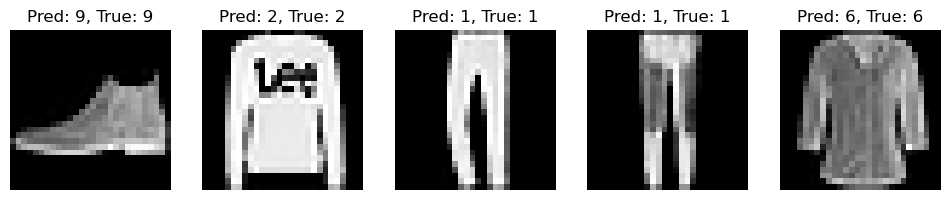

In [12]:
visualize_predictions(model, test_loader, device)

# **`Classifying Clothing Images`**

In [85]:
# Import the necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [86]:
!pip install humanize

In [87]:
!pip install GPUtil

In [88]:
!pip install matplotlib

In [89]:
# GPU check
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 16.2 GB  | Proc size: 761.3 MB
GPU RAM Free: 4014MB | Used: 1942MB | Util  32% | Total 6144MB


In [90]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [91]:
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 데이터 정규화
])

In [92]:
# 데이터셋 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 평균과 표준편차로 정규화
])

# FashionMNIST 데이터셋 다운로드 및 로드
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# 시험삼아 데이터 로드
dataiter = iter(trainloader)
images, labels = next(dataiter)  # 배치 가져오기

# 데이터 확인
print(images.shape)  # (batch_size, 1, 28, 28) 형인지 확인
print(labels.shape)  # (batch_size, ) 형인지 확인


torch.Size([64, 1, 28, 28])
torch.Size([64])


In [93]:
# 데이터셋 변환 및 데이터 로더 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 평균과 표준편차로 정규화
])

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# Define the network architecture
model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

# Define the loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training Loop
epochs = 30
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    model.train()  # Set the model to training mode
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)  # Flatten the input

        optimizer.zero_grad()  # Zero the gradients
        output = model(images)  # Forward pass
        loss = criterion(output, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimizer step

        running_loss += loss.item()  # Total loss

    # Validation pass
    model.eval()  # Set the model to evaluation mode
    test_loss, accuracy = 0, 0
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in testloader:
            images = images.view(images.shape[0], -1)  # Flatten the input
            log_ps = model(images)  # Get model output
            test_loss += criterion(log_ps, labels)  # Calculate loss

            ps = torch.exp(log_ps)  # Convert log probabilities to probabilities
            top_p, top_class = ps.topk(1, dim=1)  # Get top class
            equals = top_class == labels.view(*top_class.shape)  # Compare with true labels
            accuracy += torch.mean(equals.type(torch.FloatTensor))  # Calculate accuracy

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print(f"Epoch: {e + 1}/{epochs}.. "
        f"Training loss: {running_loss/len(trainloader):.3f}.. "
        f"Test loss: {test_loss/len(testloader):.3f}.. "
        f"Test Accuracy: {accuracy/len(testloader):.3f}")


Epoch: 1/30.. Training loss: 0.596.. Test loss: 0.460.. Test Accuracy: 0.834
Epoch: 2/30.. Training loss: 0.451.. Test loss: 0.418.. Test Accuracy: 0.852
Epoch: 3/30.. Training loss: 0.424.. Test loss: 0.410.. Test Accuracy: 0.857
Epoch: 4/30.. Training loss: 0.399.. Test loss: 0.394.. Test Accuracy: 0.855
Epoch: 5/30.. Training loss: 0.385.. Test loss: 0.380.. Test Accuracy: 0.864
Epoch: 6/30.. Training loss: 0.377.. Test loss: 0.372.. Test Accuracy: 0.865
Epoch: 7/30.. Training loss: 0.360.. Test loss: 0.376.. Test Accuracy: 0.869
Epoch: 8/30.. Training loss: 0.355.. Test loss: 0.361.. Test Accuracy: 0.874
Epoch: 9/30.. Training loss: 0.351.. Test loss: 0.367.. Test Accuracy: 0.867
Epoch: 10/30.. Training loss: 0.341.. Test loss: 0.357.. Test Accuracy: 0.871
Epoch: 11/30.. Training loss: 0.344.. Test loss: 0.356.. Test Accuracy: 0.874
Epoch: 12/30.. Training loss: 0.334.. Test loss: 0.366.. Test Accuracy: 0.871
Epoch: 13/30.. Training loss: 0.334.. Test loss: 0.350.. Test Accuracy: 0

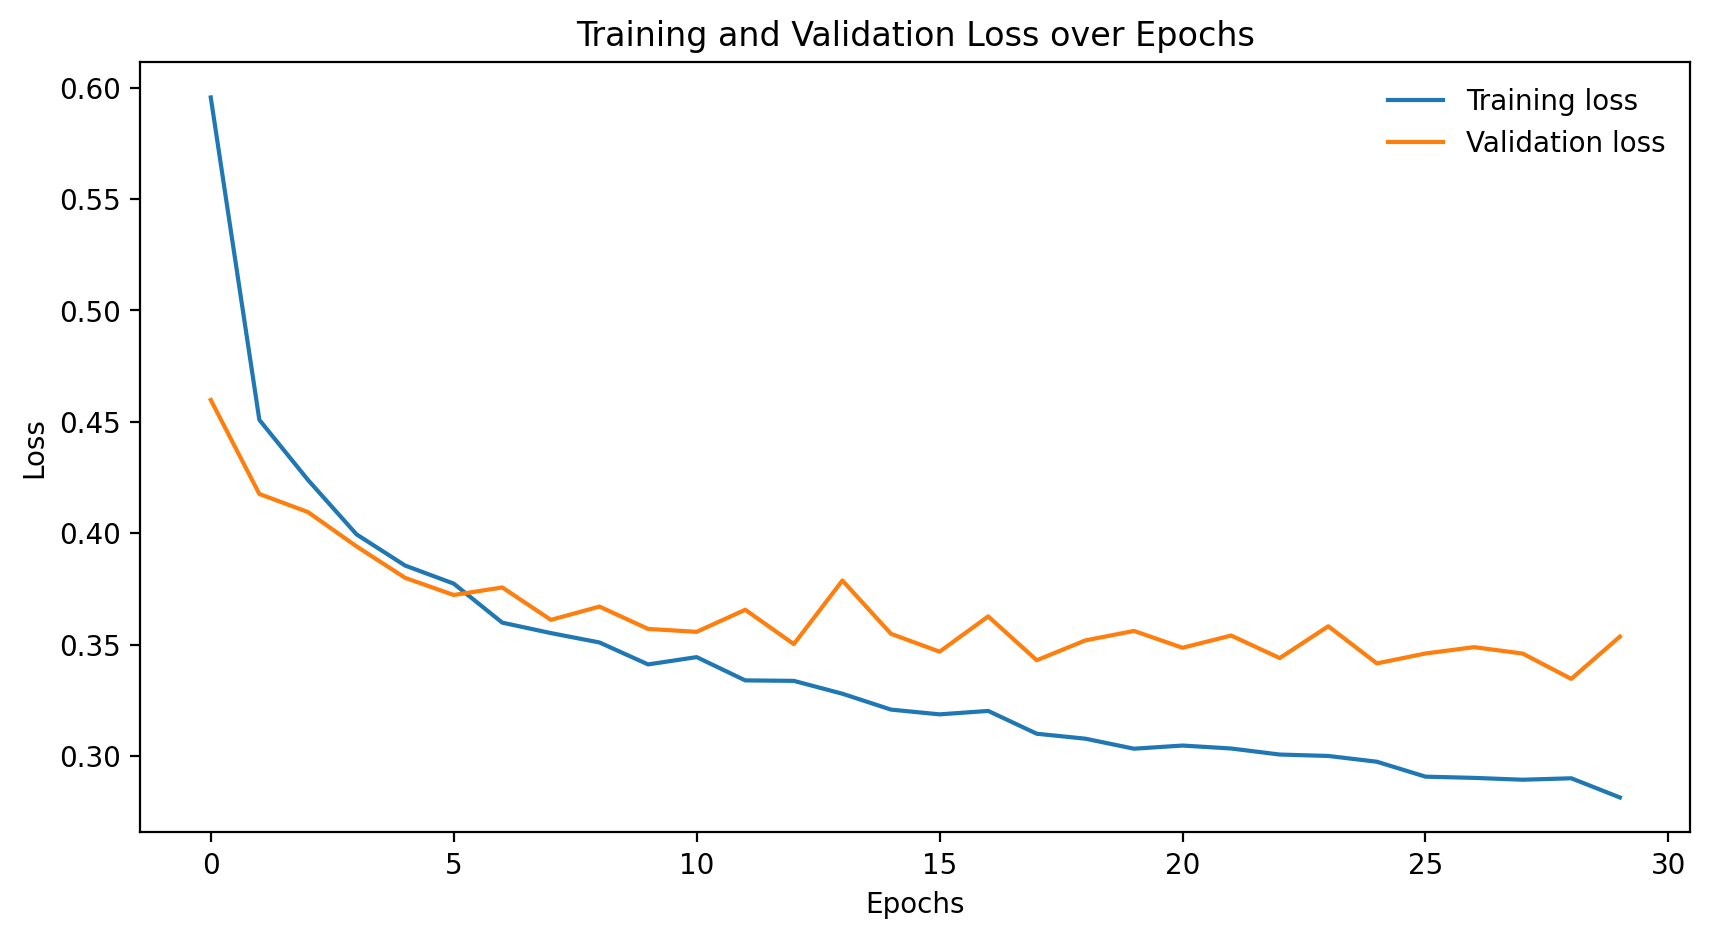

In [111]:
# 손실 그래프 시각화
plt.figure(figsize=(10, 5))  # 그림의 크기 지정
plt.plot(train_losses, label="Training loss")  # 훈련 손실
plt.plot(test_losses, label="Validation loss")  # 검증 손실
plt.legend(frameon=False)  # 범례 추가 (테두리 없음)
plt.xlabel("Epochs")  # x축 레이블
plt.ylabel("Loss")  # y축 레이블
plt.title("Training and Validation Loss over Epochs")  # 제목
plt.show()  # 그래프 표시


**Overfitting**

The training loss decreases with each epoch but the validation loss increases after some epochs. It is a clear case of overfitting. Solutions to tackle overfitting:

1. Early stopping - From the graph it's clear that on stopping at 10 epochs I can get a better validation as well as training loss.

2. Dropout - Randomly drop input units.

과적합(Overfitting)

훈련 손실은 에포크가 지남에 따라 감소하지만, 검증 손실은 몇 개의 에포크 이후 증가합니다. 이는 명백한 과적합 사례입니다. 과적합을 해결하기 위한 방법은 다음과 같습니다:


조기 중단(Early stopping) - 그래프를 보면 10 에포크에서 학습을 중단하면 더 나은 검증 및 훈련 손실을 얻을 수 있습니다.



드롭아웃(Dropout) - 입력 단위를 무작위로 제거합니다.

In [115]:
# Define view_classify function
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

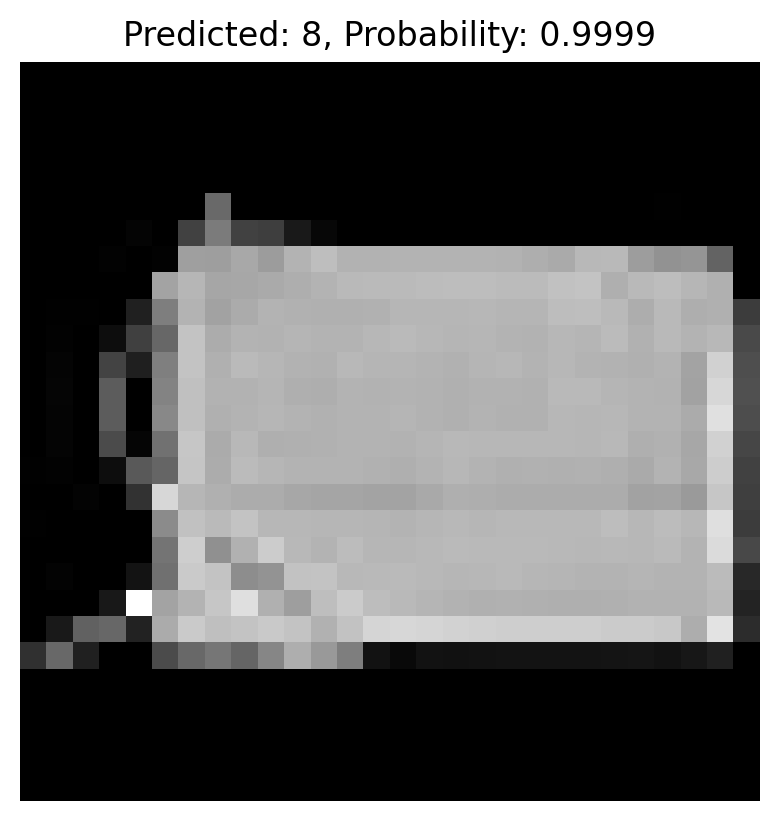

In [129]:
import matplotlib.pyplot as plt
import torch

# Inline plotting commands for Jupyter Notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Testing the network
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]

# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (log softmax) for img
ps = torch.exp(model(img))

# Define the view_classify function
def view_classify(img, ps, version='Fashion'):
    """Function for displaying an image and its predicted probability distribution"""
    img = img.view(28, 28).detach().numpy()  # 2D 이미지로 변환
    plt.imshow(img, cmap='gray')  # 이미지 시각화
    plt.title(f'Predicted: {ps.argmax().item()}, Probability: {ps.max().item():.4f}')  # 예측 및 확률 표시
    plt.axis('off')  # 축 비활성화
    plt.show()  # 그래프 표시

# Plot the image and probabilities using the view_classify function
view_classify(img, ps, version='Fashion')


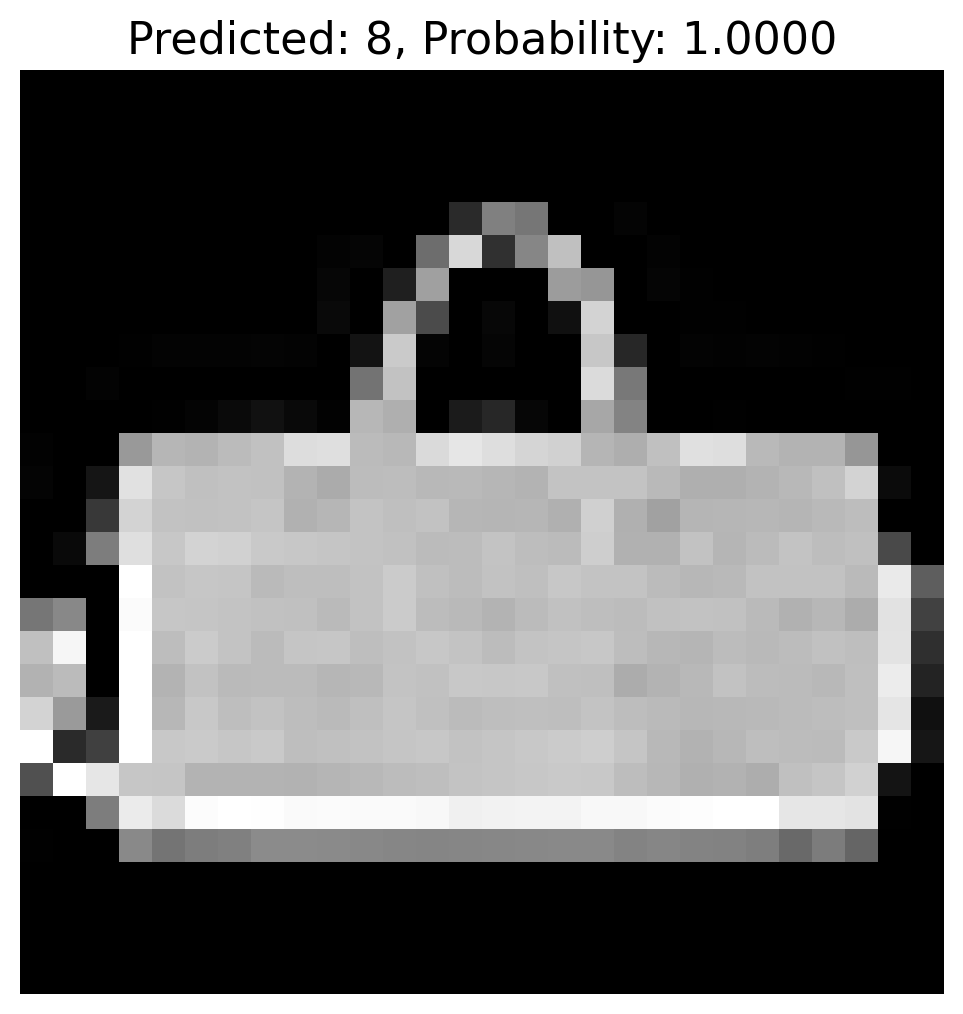

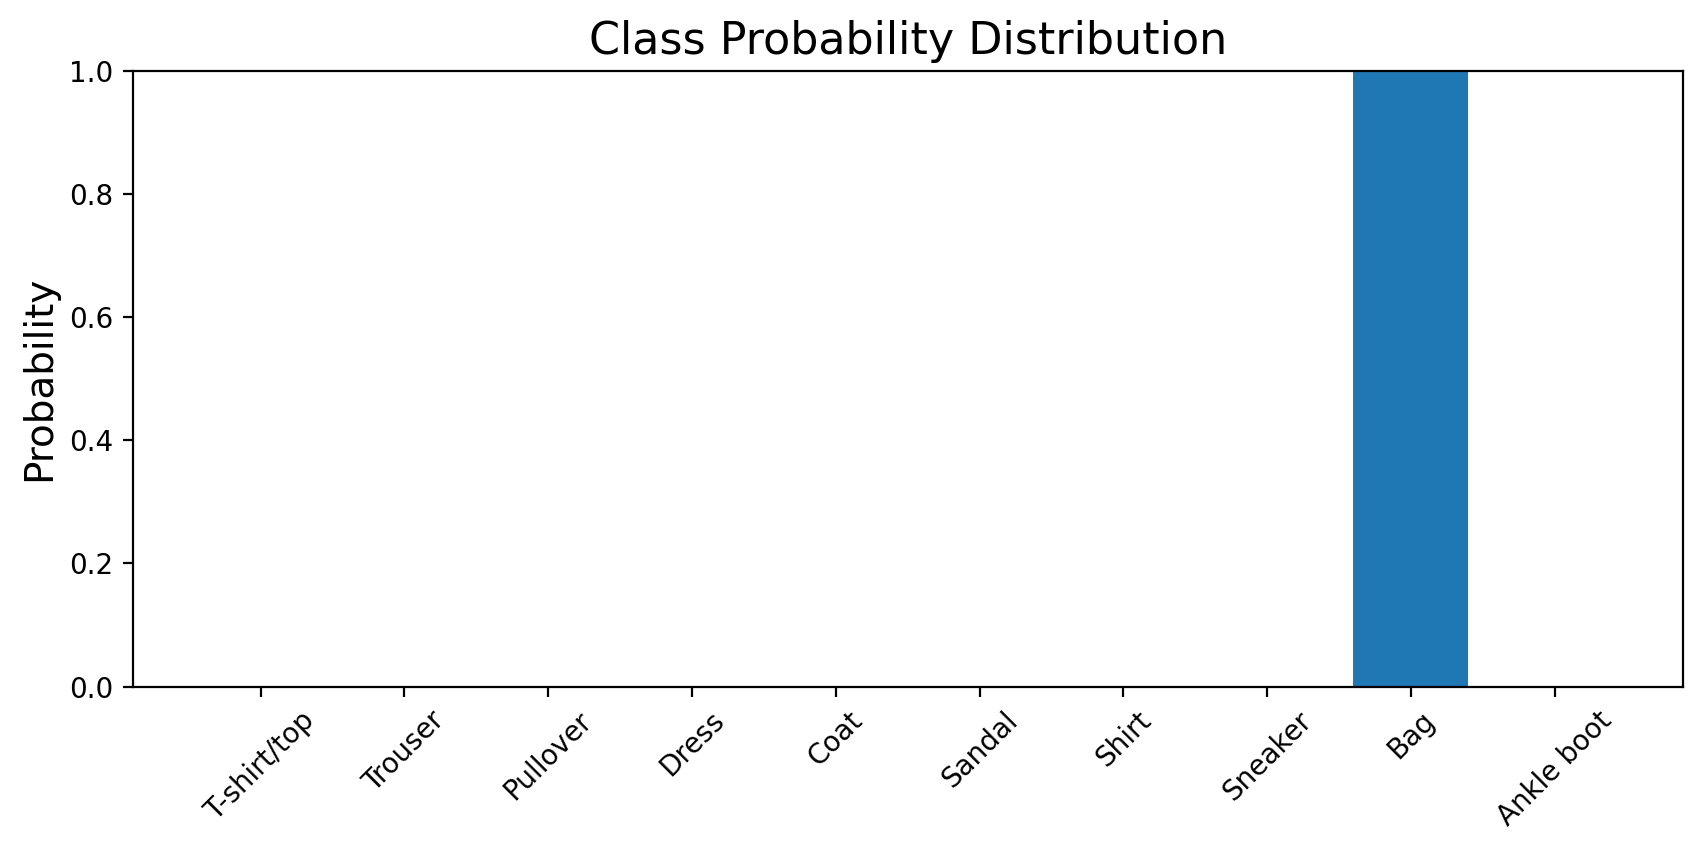

In [128]:
import matplotlib.pyplot as plt
import torch

# Inline plotting commands for Jupyter Notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Testing the network
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]

# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (log softmax) for img
ps = torch.exp(model(img))

# Define the view_classify function
def view_classify(img, ps, version='Fashion'):
    """Function for displaying an image and its predicted probability distribution"""
    
    # 1. Display the image
    plt.figure(figsize=(6, 6))  # 이미지 크기 지정
    img = img.view(28, 28).detach().numpy()  # 2D 이미지로 변환
    plt.imshow(img, cmap='gray')  # 이미지 시각화
    plt.title(f'Predicted: {ps.argmax().item()}, Probability: {ps.max().item():.4f}', fontsize=16)  # 타이틀 크기 조정
    plt.axis('off')  # 축 비활성화

    # 2. Display the probability distribution as a bar chart
    plt.figure(figsize=(10, 4))  # 바 차트 크기 지정
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  # 클래스 이름
    plt.bar(classes, ps.view(-1).detach().numpy())  # 확률 바 차트
    plt.title('Class Probability Distribution', fontsize=16)  # 타이틀 크기 조정
    plt.ylabel('Probability', fontsize=14)  # y축 레이블
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.ylim(0, 1)  # y축 범위 설정
    plt.show()  # 그래프 표시

# Plot the image and probabilities using the view_classify function
view_classify(img, ps, version='Fashion')

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34228\1454018792.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(classes, rotation=45)  # x축 레이블 회전


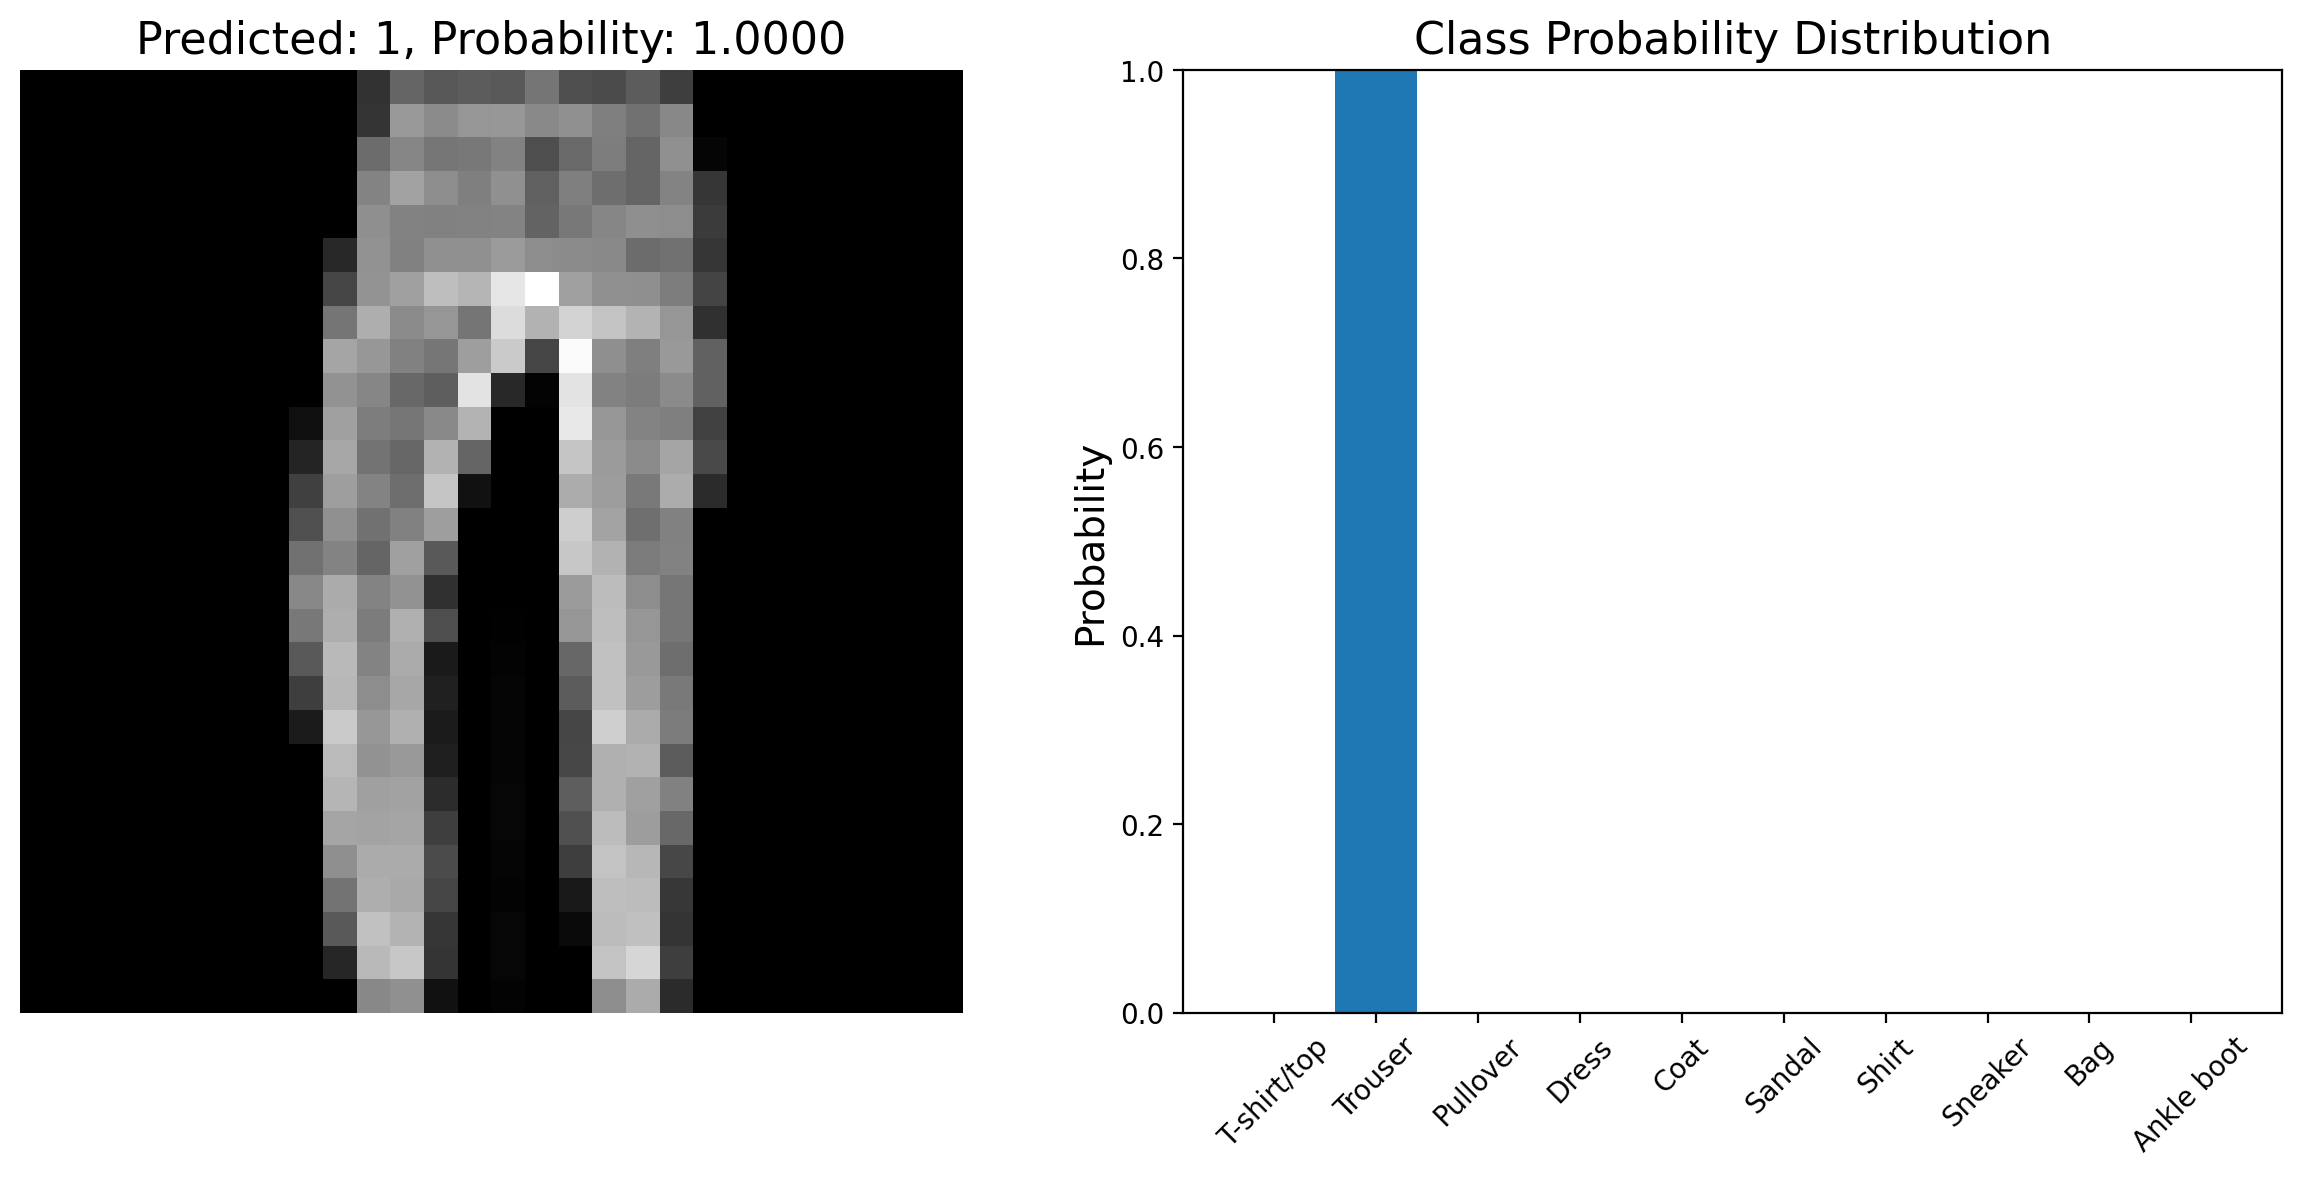

In [134]:
import matplotlib.pyplot as plt
import torch

# Inline plotting commands for Jupyter Notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Testing the network
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]

# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (log softmax) for img
ps = torch.exp(model(img))

# Define the view_classify function
def view_classify(img, ps, version='Fashion'):
    """Function for displaying an image and its predicted probability distribution"""
    
    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # 1. Display the image in the first subplot
    img = img.view(28, 28).detach().numpy()  # 2D 이미지로 변환
    axes[0].imshow(img, cmap='gray')  # 이미지 시각화
    axes[0].set_title(f'Predicted: {ps.argmax().item()}, Probability: {ps.max().item():.4f}', fontsize=16)  # 타이틀 크기 조정
    axes[0].axis('off')  # 축 비활성화

    # 2. Display the probability distribution as a bar chart in the second subplot
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  # 클래스 이름
    axes[1].bar(classes, ps.view(-1).detach().numpy())  # 확률 바 차트
    axes[1].set_title('Class Probability Distribution', fontsize=16)  # 타이틀 크기 조정
    axes[1].set_ylabel('Probability', fontsize=14)  # y축 레이블
    axes[1].set_xticklabels(classes, rotation=45)  # x축 레이블 회전
    axes[1].set_ylim(0, 1)  # y축 범위 설정
    
    # Show the plots
    plt.tight_layout()  # 레이아웃 조정
    plt.show()  # 그래프 표시

# Plot the image and probabilities using the view_classify function
view_classify(img, ps, version='Fashion')


**Saving the model**

In [106]:
print("My model: \n\n", model, "\n")
print("The state dict keys: \n\n", model.state_dict().keys())

My model: 

 Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
  (10): LogSoftmax(dim=1)
) 

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias'])


#### 모델 설명

-   **Linear Layers (선형층)**:
    
    -   `(0): Linear(in_features=784, out_features=256)`는 입력 특성이 784개(28x28 이미지)이고, 출력 특성이 256개인 선형 변환을 의미합니다.
    -   같은 방식으로 다른 다양한 선형 변환이 후속 층들에 추가되어 있습니다.
    
-   **ReLU (비선형 활성화 함수)**:
    
    -   Relu층은 비선형성을 추가하여 모델이 다양한 패턴을 학습할 수 있도록 합니다.
    
-   **Dropout**:
    
    -   데이터 과적합을 방지하기 위해 사용되는 기법입니다. 서브 샘플로서 무작위로 입력 유닛을 제거하여 학습 과정에서 모델의 일반화를 돕습니다.
    
-   **LogSoftmax**:
    
    -   최종 출력층으로, 클래스 확률의 로그를 계산하여 다중 클래스 분류 문제에서 사용됩니다.
    

### 2\. 상태 사전 출력

print("The state dict keys: \n\n", model.state_dict().keys())


이 코드에서는 모델의 상태 사전(state dict)의 키를 출력합니다. 상태 사전은 모델의 모든 학습 가능한 파라미터(가중치 및 편향)를 담고 있습니다. 출력 내용은 다음과 같습니다:

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias'])


#### 상태 사전 설명

-   `0.weight`, `0.bias`: 첫 번째 선형층(784 -> 256)의 가중치와 편향을 나타냅니다.
-   `3.weight`, `3.bias`: 두 번째 선형층(256 -> 128)의 가중치와 편향을 나타냅니다.
-   `6.weight`, `6.bias`: 세 번째 선형층(128 -> 64)의 가중치와 편향을 나타냅니다.
-   `9.weight`, `9.bias`: 마지막 선형층(64 -> 10)의 가중치와 편향을 나타냅니다.

이 상태 사전은 모델의 학습이 완료된 후 모델을 저장하거나 로드하는 데 사용됩니다. 각 키는 특정 레이어의 가중치 및 편향을 식별할 수 있도록 되어 있습니다.

### 요약

-   모델 구조는 여러 층으로 구성되어 있으며, Linear, ReLU, Dropout, LogSoftmax 등 다양한 구성 요소로 이루어져 있습니다.
-   상태 사전은 각 레이어의 가중치와 편향을 저장하고 관리하는 방식입니다.

In [98]:
torch.save(model.state_dict(), 'checkpoint.pth')

**Load the saved model**

In [99]:
state_dict = torch.load("checkpoint.pth")
print(state_dict.keys())

odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias'])


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34228\481109060.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("checkpoint.pth")


주어진 코드는 PyTorch를 사용하여 저장된 모델의 상태 사전(state dict)을 로드하고, 그 키를 출력하는 부분입니다. 또한, 경고 메시지가 나타나는 부분도 포함되어 있습니다. 아래에서 각 부분을 자세히 설명하겠습니다.

### 1\. 모델 상태 사전 로드

state_dict = torch.load("checkpoint.pth")
print(state_dict.keys())

이 코드는 `checkpoint.pth` 파일에서 모델의 상태 사전을 로드합니다. `state_dict`는 모델의 가중치와 편향 같은 학습 가능한 매개변수를 포함합니다. 이 후에는 키를 출력하여 저장된 매개변수를 확인합니다.

#### 출력 예시:

출력 예시:
odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias'])

-   이 출력은 로드된 상태 사전에 포함된 각 매개변수의 이름(키)을 나열합니다.
-   예를 들어, `'0.weight'`와 `'0.bias'`는 첫 번째 선형 층에 대한 가중치와 편향을 의미합니다.

### 2\. 경고 메시지

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34228\481109060.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling..

이 경고는 `torch.load()`를 사용할 때 `weights_only=False` 설정이 기본값이라는 내용입니다. 이 설정은 모델 저장 및 로드 시 보안 문제가 발생할 수 있음을 알립니다.

#### 경고 내용 설명:

-   **보안 관련**: 비신뢰 모델이나 외부 출처의 모델을 로드할 경우 악성 코드 실행 위험이 있습니다. 따라서, 사용자에게 신뢰할 수 없는 소스에서 모델을 로드할 때 주의를 기울이도록 하고 있습니다.
-   **weights\_only**: 향후 버전에서는 이 기본값이 `True`로 변경될 예정입니다. 이는 사용자가 고의적으로 혹은 실수로 신뢰할 수 없는 데이터 또는 객체를 로드하지 않도록 하기 위한 것입니다.
-   **권장 사항**: 만약 모델의 가중치만 로드할 경우, `torch.load("checkpoint.pth", weights_only=True)`와 같은 식으로 명시적으로 설정하는 것이 좋습니다.

### 요약

-   `torch.load("checkpoint.pth")`를 통해 모델의 상태 사전을 로드하고, 그 키를 출력하여 어떤 매개변수가 저장되어 있는지 확인합니다.
-   경고 메시지는 `torch.load()` 사용 시 보안 문제를 알려주며, 향후 업데이트에 대한 주의를 요구합니다. 안전한 모델 로드 관행을 따르는 것이 중요합니다.

In [100]:
# Load the state dict to the network
model.load_state_dict(state_dict)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
  (10): LogSoftmax(dim=1)
)
